In [5]:
# importações:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

## Pré-Procesamento

In [6]:
# carregando datasets:
top200_dataset = pd.read_csv("/content/top_200_password_2020_by_country.csv")
common_passwords_dataset = pd.read_csv("/content/common_passwords.csv")

In [7]:
# Renomeando coluna password para Password
common_passwords_dataset = common_passwords_dataset.rename(columns={'password': 'Password'})

# Juntando os dois datasets pela coluna Password
dataset_principal_bruto = top200_dataset.merge(common_passwords_dataset, on="Password", how="inner")

In [8]:
# Limitando nosso dataset para possuir somente dados do Brasil
dataset_principal = dataset_principal_bruto.loc[dataset_principal_bruto["country"] == "Brazil"]

# Eliminando as colunas country_code e country, visto que sempre serao br e Brazil
dataset_principal = dataset_principal.drop(["country_code", "country"], axis=1)

# Criando um dataset com somente as colunas numericas
dataset_numerico = dataset_principal.select_dtypes(include=[np.number])

# Removendo os elementos que são Nan no dataset numerico
dataset_numerico_sem_nan = dataset_numerico.dropna(subset=["Global_rank"])
dataset_numerico_sem_nan

,Rank,User_count,Global_rank,Time_to_crack_in_seconds,length,num_chars,num_digits,num_upper,num_lower,num_special,num_vowels,num_syllables
3,1,1003925,1.0,0,6,0,6,0,0,0,0,1
52,31,27345,5.0,0,8,8,0,0,8,0,2,2
140,2,326815,2.0,0,9,0,9,0,0,0,0,1
189,4,143513,3.0,0,5,0,5,0,0,0,0,1
238,16,40939,15.0,0,6,3,3,0,3,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4073,145,8622,57.0,0,10,1,9,0,1,0,1,1
4136,180,7213,180.0,0,6,0,6,0,0,0,0,1
4141,181,7134,197.0,0,6,0,6,0,0,0,0,1
4163,192,6512,182.0,0,9,0,9,0,0,0,0,1


In [9]:
# Criando componentes principais do nosso dataset
pca = PCA(n_components=1)
pca.fit(dataset_numerico_sem_nan)

PCA(n_components=1)

In [10]:
# Printando o resultado do PCA para analise
print("Auto-Valores")
print(pca.explained_variance_)
print()

print("Auto-Vetores")
print(pca.components_)
print()

print("Variancia Explicada")
print(pca.explained_variance_ratio_)
print()

Auto-Valores
[1.64007825e+10]

Auto-Vetores
[[-1.57081051e-04  9.99999982e-01 -1.06045170e-04 -4.29674521e-07
  -1.12075052e-06 -3.82715417e-06  2.70640365e-06 -0.00000000e+00
  -3.82715417e-06 -0.00000000e+00 -1.47934259e-06 -4.56428206e-07]]

Variancia Explicada
[0.99999961]



In [11]:
# Com base nos dados apresentados pelo PCA conseguimos identificar os campos mais importantes e
# remover campos não tão uteis para a analise em questão
dataset_principal = dataset_principal.drop(["num_upper", "num_special"], axis=1)

# Redução da coluna "Time_to_crack" uma vez que temos outra que faz a mesma coisa (Redundancia)
dataset_principal = dataset_principal.drop(["Time_to_crack"], axis=1)

dataset_principal

,Rank,Password,User_count,Global_rank,Time_to_crack_in_seconds,length,num_chars,num_digits,num_lower,num_vowels,num_syllables
3,1,123456,1003925,1.0,0,6,0,6,0,0,1
52,31,password,27345,5.0,0,8,8,0,8,2,2
140,2,123456789,326815,2.0,0,9,0,9,0,0,1
189,4,12345,143513,3.0,0,5,0,5,0,0,1
238,16,abc123,40939,15.0,0,6,3,3,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...
4172,195,anderson,5472,NaN,10800,8,8,0,8,3,3
4173,196,a123456,5466,36.0,0,7,1,6,1,1,1
4181,198,963852741,5392,NaN,0,9,0,9,0,0,1
4185,199,oracle,5041,NaN,0,6,6,0,6,3,3


In [12]:
# Alterando o valor da coluna Global_rank para boleano para que os valores nan sejam substituidos por False
dataset_principal['Global_rank'] = ~dataset_principal['Global_rank'].isna().fillna(False)

# Alterando o nome da coluna de Global_rank para In_global_rank para fazer mais sentido
dataset_principal = dataset_principal.rename(columns={"Global_rank": "In_global_rank"})
dataset_principal

,Rank,Password,User_count,In_global_rank,Time_to_crack_in_seconds,length,num_chars,num_digits,num_lower,num_vowels,num_syllables
3,1,123456,1003925,True,0,6,0,6,0,0,1
52,31,password,27345,True,0,8,8,0,8,2,2
140,2,123456789,326815,True,0,9,0,9,0,0,1
189,4,12345,143513,True,0,5,0,5,0,0,1
238,16,abc123,40939,True,0,6,3,3,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...
4172,195,anderson,5472,False,10800,8,8,0,8,3,3
4173,196,a123456,5466,True,0,7,1,6,1,1,1
4181,198,963852741,5392,False,0,9,0,9,0,0,1
4185,199,oracle,5041,False,0,6,6,0,6,3,3


In [13]:
# Verificando se não existem valores null ou nan em nosso dataset
print(dataset_principal.isnull().sum())

Rank                        0
Password                    0
User_count                  0
In_global_rank              0
Time_to_crack_in_seconds    0
length                      0
num_chars                   0
num_digits                  0
num_lower                   0
num_vowels                  0
num_syllables               0
dtype: int64


In [14]:
# Deletando a coluna password para fazer a mineração, visto que ela é composta de strings
dataset_principal_sem_password = dataset_principal.drop(["Password"], axis=1)
dataset_principal_sem_password.head()

,Rank,User_count,In_global_rank,Time_to_crack_in_seconds,length,num_chars,num_digits,num_lower,num_vowels,num_syllables
3,1,1003925,True,0,6,0,6,0,0,1
52,31,27345,True,0,8,8,0,8,2,2
140,2,326815,True,0,9,0,9,0,0,1
189,4,143513,True,0,5,0,5,0,0,1
238,16,40939,True,0,6,3,3,3,1,1


## Transformação:
- Como nós decidimos fazer um agrupamento não é necessário alterar nosso dataset, visto que esse modelo não necessita de um Label.

## Mineração

In [15]:
# Dividindo o nosso dataset em train e teste
dataset_treino, dataset_teste = train_test_split(dataset_principal_sem_password, test_size=0.2, random_state=42)

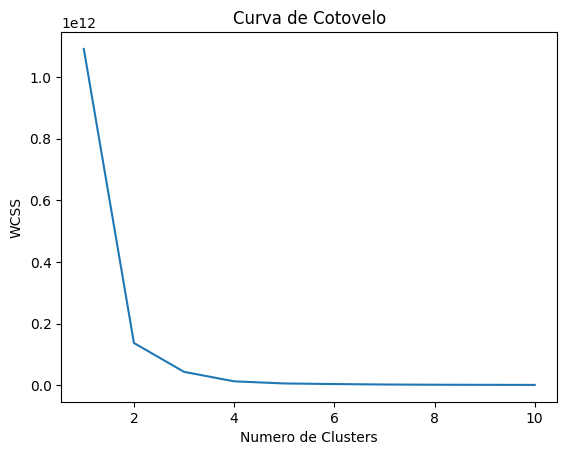

In [16]:
# Cria a Curva de Cotovelo para encontrar o Numero Ideal de Clusters
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(dataset_treino)
    wcss.append(kmeans.inertia_)

# Mostra o Gráfico
plt.plot(range(1, 11), wcss)
plt.title('Curva de Cotovelo')
plt.xlabel('Numero de Clusters')
plt.ylabel('WCSS')
plt.show()

In [23]:
# Cria o modelo KMeans usando o numero de clusters indicado pela "curva do cotovelo"
kmeans = KMeans(n_clusters=4)

# Treina o nosso modelo com base no nosso dataset
kmeans.fit(dataset_treino)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

In [24]:
# Alterando nosso dataset de treino para adicionar uma coluna Grupo
dataset_treino["Grupo"] = kmeans.labels_

# mostrando os dados após alteração
dataset_treino.head()

,Rank,User_count,In_global_rank,Time_to_crack_in_seconds,length,num_chars,num_digits,num_lower,num_vowels,num_syllables,Grupo
3791,57,18116,False,1020,7,7,0,7,4,2,0
3853,70,15886,False,5,8,8,0,8,3,3,0
3471,177,7391,False,10800,8,8,0,8,4,3,0
3,1,1003925,True,0,6,0,6,0,0,1,1
730,10,54441,True,0,6,0,6,0,0,1,0


In [26]:
# Mostra o peso de cada coluna para cada um dos grupos criados
for indexi, i in enumerate(kmeans.cluster_centers_):
  print(f"\nNivel de importancia das colunas para o grupo {kmeans.labels_[indexi]}: ")
  for indexj, j in enumerate(i):
    print(f"{dataset_treino.columns[indexj]}:{j:.2f}")


Nivel de importancia das colunas para o grupo 0: 
Rank:100.90
User_count:15727.68
In_global_rank:0.48
Time_to_crack_in_seconds:501.99
length:6.82
num_chars:3.87
num_digits:2.95
num_lower:3.87
num_vowels:1.60
num_syllables:1.60
Grupo:-0.00

Nivel de importancia das colunas para o grupo 0: 
Rank:1.00
User_count:1003925.00
In_global_rank:1.00
Time_to_crack_in_seconds:0.00
length:6.00
num_chars:0.00
num_digits:6.00
num_lower:0.00
num_vowels:0.00
num_syllables:1.00
Grupo:1.00

Nivel de importancia das colunas para o grupo 0: 
Rank:2.00
User_count:326815.00
In_global_rank:1.00
Time_to_crack_in_seconds:0.00
length:9.00
num_chars:0.00
num_digits:9.00
num_lower:0.00
num_vowels:0.00
num_syllables:1.00
Grupo:2.00

Nivel de importancia das colunas para o grupo 1: 
Rank:6.00
User_count:105206.25
In_global_rank:1.00
Time_to_crack_in_seconds:0.00
length:5.75
num_chars:0.00
num_digits:5.75
num_lower:0.00
num_vowels:0.00
num_syllables:1.00
Grupo:3.00


In [33]:
# Descobrindo o score do nosso modelo
predicao = kmeans.fit_predict(dataset_teste)
score = silhouette_score(dataset_teste, predicao)
print(score)

0.5001005878957488


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
